# Using _EarlyStopping_ with _GradientTape_ in _TensorFlow 2.0_

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# from keras.models import Sequential
# from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity

### Brief introduction about dataset:

_banknote authentication_ Data Set

Refer:

http://archive.ics.uci.edu/ml/datasets/banknote+authentication


You have to predict _class_ attribute

In [2]:
# Assign column names to dataset-
colnames = ['variance-wavelet_transformed_img', 'skewness-wavelet_transformed_img',
            'curtosis-wavelet_transformed_img', 'entropy-img', 'class']

In [3]:
# Read in data-
banknote_data = pd.read_csv("data_banknote_authentication.txt", names = colnames)

In [4]:
# Get shape/dimension of data-
banknote_data.shape

(1372, 5)

In [5]:
# Check for missing values in dataset-
# Get columns with True/False containing NAs-
banknote_data.isnull().values.any()

False

In [6]:
# Get distribution of target attribute: 'class'-
banknote_data['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

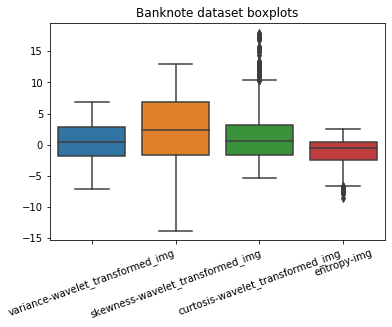

In [7]:
sns.boxplot(data=banknote_data.iloc[:, :-1])

plt.title("Banknote dataset boxplots")
plt.xticks(rotation = 20)
plt.show()

### Observations:
The attributes of the dataset seem to have a normal distribution with outliers for the last two attributes

In [8]:
# Divide data into features (X) and label (y)-

# 'X' contains attributes-
X = banknote_data.drop('class', axis = 1)

# 'y' contains labels-
y = banknote_data['class']

In [9]:
# Standardize certain features/attributes in dataset-
rb_scaler = RobustScaler()

# Standardize features (X) in dataset-
X_std = rb_scaler.fit_transform(X)

In [10]:
# Divide attributes & labels into training & testing sets-
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.30)
print("\n\nDimensions of training and testing sets are:")
print("X_train = {0}, y_train = {1}, X_test = {2} & y_test = {3}\n\n".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))



Dimensions of training and testing sets are:
X_train = (960, 4), y_train = (960,), X_test = (412, 4) & y_test = (412,)




In [11]:
# Convert training and testing sets to floating types as numpy arrays-
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

y_train = np.asarray(y_train, dtype = np.float16)
y_test = np.asarray(y_test, dtype = np.float16)

In [12]:
def create_nn():
    """
    Function to create a
    Neural Network
    """
    model = Sequential()                                                    

    model.add(
        Dense(
            units = 4, activation = 'relu',
            kernel_initializer = tf.keras.initializers.GlorotNormal(),
            input_shape = (4,)
        )
    )

    model.add(
        Dense(
            units = 3, activation = 'relu',
            kernel_initializer = tf.keras.initializers.GlorotNormal()
        )
    )

    model.add(
        Dense(
            units = 1, activation = 'sigmoid'
        )
    )

    """
    # Compile the defined NN model above-
    model.compile(
        loss = 'binary_crossentropy',  # loss = 'categorical_crossentropy'
        optimizer = tf.keras.optimizers.Adam(lr = 0.001),
        metrics=['accuracy']
    )
    """

    return model



### First _fit()_ method with _EarlyStopping_ is used:

In [13]:
# Instantiate a model-
model = create_nn()

In [14]:
# Save weights for fair comparison-
model.save_weights("Random_Weights.h5", overwrite=True)

### _fit()_ method arguments:

1. _batch_size:_ Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. Do not specify the batch_size if your data is in the form of symbolic tensors, datasets, generators, or keras.utils.Sequence instances (since they generate batches).

1. _epochs:_ Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided. Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs, but merely until the epoch of index epochs is reached.

1. _shuffle:_ Boolean (whether to shuffle the training data before each epoch) or str (for 'batch'). 'batch' is a special option for dealing with the limitations of HDF5 data; __it shuffles in batch-sized chunks__. Has no effect when _steps_per_epoch_ is not None.

In [15]:
# Compile model-
model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(lr = 0.001),
    metrics = ['accuracy'],
    shuffle = True
    )

In [16]:
# Define early stopping-
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3,
    min_delta = 0.001, mode = 'min'
)

In [17]:
# Train defined model-
history_orig = model.fit(
    x = X_train, y = y_train,
    batch_size = 32, epochs = 500,
    validation_data = (X_test, y_test),
    callbacks = [callback],
    verbose = 1
)


Train on 960 samples, validate on 412 samples
Epoch 1/500
960/960 [==============================] - 1s 781us/sample - loss: 0.7348 - accuracy: 0.1458 - val_loss: 0.7222 - val_accuracy: 0.1772
Epoch 2/500
960/960 [==============================] - 0s 82us/sample - loss: 0.7185 - accuracy: 0.2292 - val_loss: 0.7112 - val_accuracy: 0.2913
Epoch 3/500
960/960 [==============================] - 0s 82us/sample - loss: 0.7087 - accuracy: 0.3406 - val_loss: 0.7039 - val_accuracy: 0.3786
Epoch 4/500
960/960 [==============================] - 0s 93us/sample - loss: 0.7020 - accuracy: 0.3927 - val_loss: 0.6989 - val_accuracy: 0.4175
Epoch 5/500
960/960 [==============================] - 0s 85us/sample - loss: 0.6971 - accuracy: 0.4458 - val_loss: 0.6950 - val_accuracy: 0.4806
Epoch 6/500
960/960 [==============================] - 0s 91us/sample - loss: 0.6930 - accuracy: 0.5031 - val_loss: 0.6910 - val_accuracy: 0.5170
Epoch 7/500
960/960 [==============================] - 0s 95us/sample - loss:

In [ ]:
history_orig.history['val_loss']

### Sanity Check: see whether _EarlyStopping_ is actually working:
Using _patience_ of 3 and _min_delta_ = 0.001 while monitoring the _validation loss_ ('val_loss')

In [18]:
# 'min_delta'-
md = 0.001

In [19]:
# Get the last three values-
x = history_orig.history['val_loss'][-3:]

In [20]:
print(x)

[0.05953425924899509, 0.05903084709951021, 0.05866503379153974]


In [21]:
# Compute absolute consecutive difference between each subsequent elements-
np.abs(np.diff(x, n = 1))

array([0.00050341, 0.00036581])

In [22]:
# Check whether absolute consecutive differences between each subsequent elements
# is greater than 'min_delta'-
np.abs(np.diff(x, n = 1)) > md

array([False, False])

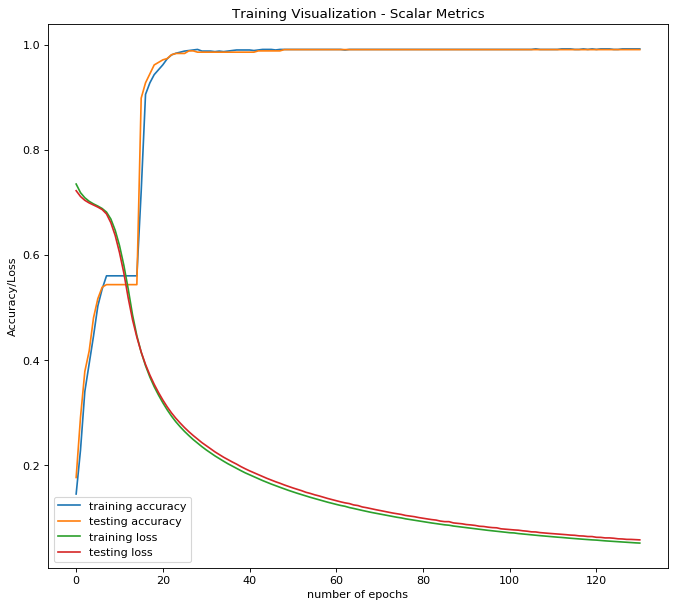

In [23]:
# Visualize training progress of neural network model-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_orig.history['accuracy'], label = 'training accuracy')
plt.plot(history_orig.history['val_accuracy'], label = 'testing accuracy')
plt.plot(history_orig.history['loss'], label = 'training loss')
plt.plot(history_orig.history['val_loss'], label = 'testing loss')

plt.title("Training Visualization - Scalar Metrics")
plt.xlabel("number of epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(loc = 'best')
plt.show()


In [26]:
# Make predictions using trained model-
y_pred_orig = model.predict_classes(X_test)

In [27]:
accuracy_orig = accuracy_score(y_test, y_pred_orig)
precision_orig = precision_score(y_test, y_pred_orig)
recall_orig = recall_score(y_test, y_pred_orig)

In [28]:
print("\n'model.fit()' metrics on testing set:")
print("accuracy = {0:.4f}, precision = {1:.4f} & recall = {2:.4f}\n".format(accuracy_orig,
                                                                           precision_orig,
                                                                           recall_orig))


'model.fit()' metrics on testing set:
accuracy = 0.9903, precision = 0.9792 & recall = 1.0000



In [29]:
print("\nConfusion matrix of 'model.fit()':\n")
print("{0}\n".format(confusion_matrix(y_test, y_pred_orig)))


Confusion matrix of 'model.fit()':

[[220   4]
 [  0 188]]



### Now, use 'GradientTape' to train another instance of defined model-

In [30]:
# Create datasets to be used for GradientTape-

# Use tf.data to batch and shuffle the dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).shuffle(32).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test, y_test)).shuffle(32).batch(32)


In [38]:
del model_gt

In [31]:
# Instantiate a model-
model_gt = create_nn()

In [32]:
# Restore random weights as used by the previous model for fair comparison-
model_gt.load_weights("Random_Weights.h5")

In [33]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.001)

In [34]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name = 'train_accuracy')

In [35]:
# Use tf.GradientTape to train the model-

@tf.function
def train_step(data, labels):
    """
    Function to perform one step of Gradient
    Descent optimization
    """

    with tf.GradientTape() as tape:
        predictions = model_gt(data)
        loss = loss_fn(labels, predictions)

    gradients = tape.gradient(loss, model_gt.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_gt.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

    

In [36]:
@tf.function
def test_step(data, labels):
    """
    Function to test model performance
    on testing dataset
    """
    
    predictions = model_gt(data)
    t_loss = loss_fn(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


In [37]:
EPOCHS = 500

# User input-
minimum_delta = 0.001
patience = 3

patience_val = np.zeros(patience)

In [38]:
# Dictionary to hold scalar metrics-
history = {}

history['accuracy'] = np.zeros(EPOCHS)
history['val_accuracy'] = np.zeros(EPOCHS)
history['loss'] = np.zeros(EPOCHS)
history['val_loss'] = np.zeros(EPOCHS)

In [39]:
# To change all layers to have dtype float64 by default-
tf.keras.backend.set_floatx('float64')

### Logic behind manual _EarlyStopping_:
_check = np.diff(history['val_loss'][epoch - 3:epoch], n = 1) > minimum_delta_ checks whether the absolute value of the consecutive differences between the last 3 epoch's _validation loss_ is more than _minimum delta_

1. _Case - 1:_ If any of these absolute values of the consecutive differences is _greater than_ _min_delta_, then __keep training__

1. _Case - 2_: If all of these absolute values of the consecutive differences is _less than_ _min_delta_, then __Stop training__

In [40]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for x, y in train_ds:
        train_step(x, y)

    for x_t, y_t in test_ds:
        test_step(x_t, y_t)

    template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'

    history['accuracy'][epoch] = train_accuracy.result()
    history['loss'][epoch] = train_loss.result()
    history['val_loss'][epoch] = test_loss.result()
    history['val_accuracy'][epoch] = test_accuracy.result()

    print(template.format(epoch + 1, 
                          train_loss.result(), train_accuracy.result()*100,
                          test_loss.result(), test_accuracy.result()*100))

    if epoch > 2:
        # Computes absolute differences between 3 consecutive loss values-
        differences = np.abs(np.diff(history['val_loss'][epoch - 3:epoch], n = 1))
        
        # Checks whether the absolute differences is greater than 'minimum_delta'-
        check =  differences > minimum_delta
        
        # print('differences: {0}'.format(differences))
        
        # Count unique element with it's counts-
        # elem, count = np.unique(check, return_counts=True)
        # print('\nelem = {0}, count = {1}'.format(elem, count))
        
        if np.all(check == False):
        # if elem.all() == False and count == 2:
            print("\n\nEarlyStopping Evoked! Stopping training\n\n")
            break



W0125 13:57:30.250159 140664062568256 base_layer.py:1814] Layer dense_3 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Epoch 1, Loss: 0.7356, Accuracy: 14.3750, Test Loss: 0.7229, Test Accuracy: 16.311813
Epoch 2, Loss: 0.7195, Accuracy: 21.4583, Test Loss: 0.7118, Test Accuracy: 28.331045
Epoch 3, Loss: 0.7094, Accuracy: 32.7083, Test Loss: 0.7042, Test Accuracy: 36.298077
Epoch 4, Loss: 0.7026, Accuracy: 39.1667, Test Loss: 0.6992, Test Accuracy: 41.277470
Epoch 5, Loss: 0.6977, Accuracy: 43.9583, Test Loss: 0.6952, Test Accuracy: 47.561817
Epoch 6, Loss: 0.6934, Accuracy: 49.5833, Test Loss: 0.6913, Test Accuracy: 51.648354
Epoch 7, Loss: 0.6887, Accuracy: 52.8125, Test Loss: 0.6865, Test Accuracy: 53.434067
Epoch 8, Loss: 0.6818, Accuracy: 55.8333, Test Loss: 0.6779, Test Accuracy: 54.498627
Epoch 9, Loss: 0.6686, Accuracy: 56.0417, Test Loss: 0.6611, Test Accuracy: 54.429947
Epoch 10, Loss: 0.6471, Accuracy: 56.0417, Test Loss: 0.6372, Test Accuracy: 54.464287
Epoch 11, Loss: 0.6184, Accuracy: 56.0417, Test Loss: 0.6052, Test Accuracy: 54.464287
Epoch 12, Loss: 0.5823, Accuracy: 56.0417, Test Loss

In [41]:
# Make predictions using GradientTape trained model-
y_pred_gt = model_gt.predict_classes(X_test)

In [42]:
accuracy_gt = accuracy_score(y_test, y_pred_gt)
precision_gt = precision_score(y_test, y_pred_gt)
recall_gt = recall_score(y_test, y_pred_gt)

In [43]:
print("\n'GradientTape' trained model metrics on testing set:")
print("accuracy = {0:.4f}, precision = {1:.4f} & recall = {2:.4f}\n".format(accuracy_gt,
                                                                           precision_gt,
                                                                           recall_gt))



'GradientTape' trained model metrics on testing set:
accuracy = 0.9903, precision = 0.9792 & recall = 1.0000



In [44]:
print("\nConfusion matrix of 'GradientTape' trained model:\n")
print("{0}\n".format(confusion_matrix(y_test, y_pred_gt)))


Confusion matrix of 'GradientTape' trained model:

[[220   4]
 [  0 188]]



In [45]:
print("\n'model.fit()' metrics on testing set:")
print("accuracy = {0:.4f}, precision = {1:.4f} & recall = {2:.4f}\n".format(accuracy_orig,
                                                                           precision_orig,
                                                                           recall_orig))


'model.fit()' metrics on testing set:
accuracy = 0.9903, precision = 0.9792 & recall = 1.0000



In [46]:
print("\nConfusion matrix of 'model.fit()':\n")
print("{0}\n".format(confusion_matrix(y_test, y_pred_orig)))


Confusion matrix of 'model.fit()':

[[220   4]
 [  0 188]]



### Observation:
We can see that the metrics, viz., accuracy, precision, recall and confusion matrix are _identical_ for _model.fit()_ and _GradientTape_ methods

### Sanity check:

In [48]:
history['val_loss'][96:99]

array([0.08358362, 0.08275433, 0.08149289])

In [49]:
np.abs(np.diff(history['val_loss'][96:99], n = 1)) > md

array([False,  True])

### _GradientTape_:
One _epoch_ goes through all of the 960 samples or training data in training dataset. And also through all of the 412 testing data in testing dataset.

Sanity check is below-

In [53]:
# Count number of samples or training data points in training dataset-
c = 0

for x, y in train_ds:
    c += x.shape[0]

In [54]:
c

960

In [55]:
# Count number of samples or testing data points in testing dataset-
c = 0

for x, y in test_ds:
    c += x.shape[0]

In [56]:
c

412